In [69]:
#%pip install yfinance

In [149]:
import yfinance as yf
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from scipy.stats import norm
import math

import matplotlib.pyplot as plt

In [71]:
# Chargement de l'historique des actifs sur les deux dernières années
end_date = datetime.now()
strat_date = end_date - timedelta(days=2*365)
tickers = ['SAN.PA', 'BN.PA',  'AIR.PA', 'AI.PA', 'ORA.PA', 'CAP.PA', 'VIV.PA', 'CA.PA', 'ENGI.PA', 'DG.PA']
df = yf.download(tickers, start = strat_date, end=end_date)[['Close', 'Volume']]

cac40 = yf.download('^FCHI', start = strat_date, end=end_date)[['Close', 'Volume']]

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [72]:
df.head()

Price            Close                                                \
Ticker           AI.PA      AIR.PA      BN.PA      CA.PA      CAP.PA   
Date                                                                   
2023-01-30  129.703018  113.202339  46.732342  16.069134  166.543777   
2023-01-31  128.141388  112.535980  46.928230  16.005003  167.555466   
2023-02-01  127.790466  113.711906  47.292011  15.972937  170.349670   
2023-02-02  128.702866  115.397400  47.124111  16.078293  181.478287   
2023-02-03  127.492165  114.770241  47.329327  15.995840  182.104553   

Price                                                             Volume  \
Ticker          DG.PA    ENGI.PA    ORA.PA     SAN.PA    VIV.PA    AI.PA   
Date                                                                       
2023-01-30  96.130051  10.756801  8.415674  83.109283  9.450281   922207   
2023-01-31  95.871048  10.796604  8.508444  82.998215  9.362902   982086   
2023-02-01  96.870094  10.906063  8.504066  82.100380  9.395194   498535   
2023-02-02  97.166107  10.707047  8.443680  80.313980  9.469277   935729   
2023-02-03  97.443611  10.859626  8.393794  78.805260  9.402792  1217643   

Price                                                                     \
Ticker       AIR.PA    BN.PA    CA.PA  CAP.PA    DG.PA  ENGI.PA   ORA.PA   
Date                                                                       
2023-01-30  1080203  1318109  1503551  265113   832568  3784922  5398200   
2023-01-31  1357678  1195913  1947261  472465   850875  5761592  7767232   
2023-02-01  1102143  1111493  1091097  272322   907425  5894306  4980785   
2023-02-02  1394176  2013542  1805955  568976   920499  7742563  7100632   
2023-02-03  1587465  1649190  1730754  383622  1106022  5942379  7368347   

Price                         
Ticker       SAN.PA   VIV.PA  
Date                          
2023-01-30  1235322  2938565  
2023-01-31  2218706  2470382  
2023-02-01  1614583  2025489  
2023-02-02  2421074  2434350  
2023-02-03  4394526  2855250

In [73]:
df_close = df['Close']
df_volume = df['Volume']

In [74]:
# Poids des actions dans le portefeuille
weights = np.repeat(0.1, 10)

weights = pd.DataFrame({'Ticker': ['SAN.PA', 'BN.PA',  'AIR.PA', 'AI.PA', 'ORA.PA', 'CAP.PA', 'VIV.PA', 'CA.PA', 'ENGI.PA', 'DG.PA'],
                        'Weight': weights})
weights = weights.set_index('Ticker')['Weight']

print(weights)

Ticker
SAN.PA     0.1
BN.PA      0.1
AIR.PA     0.1
AI.PA      0.1
ORA.PA     0.1
CAP.PA     0.1
VIV.PA     0.1
CA.PA      0.1
ENGI.PA    0.1
DG.PA      0.1
Name: Weight, dtype: float64


In [75]:
# Détermination de l'AUM
aum = df_close@weights
portfolio = pd.DataFrame({'AUM': aum})
portfolio.head()

,AUM
Date,
2023-01-30,68.011270
2023-01-31,67.870328
2023-02-01,68.289279
2023-02-02,69.488105
2023-02-03,69.259721


In [76]:
# Performance du portefeuille
portfolio['perf'] = portfolio['AUM'].pct_change()
portfolio.dropna(inplace=True)


In [77]:
portfolio.head()

,AUM,perf
Date,,
2023-01-31,67.870328,-0.002072
2023-02-01,68.289279,0.006173
2023-02-02,69.488105,0.017555
2023-02-03,69.259721,-0.003287
2023-02-06,68.508216,-0.010851


# Volatiliy

In [78]:
# Volatilité annualisé du portefeuille
std_dev = portfolio.std()*np.sqrt(252)
std_dev

AUM     74.064066
perf     0.127604
dtype: float64

In [79]:
# Performance du benchmark
cac40_df = cac40['Close']
cac40_df ['perf'] = cac40_df.pct_change()
cac40_df.dropna(inplace=True)


In [80]:
# Volatilité du benchmark
cac40_df.std()*np.sqrt(252)

Ticker
^FCHI    4952.982724
perf        0.133702
dtype: float64

# Tracking error

In [81]:
# Tracking error
portfolio['benchmark'] = cac40_df['perf']
portfolio['tracking_error'] = portfolio['perf'] - portfolio['benchmark']
TError = portfolio['tracking_error'].std()*np.sqrt(252) # Annualisation

TError

0.07697383277871685

# Value at risk

## VaR historique

In [82]:
VaR = portfolio.quantile(1-0.99)*np.sqrt(20) # 1-day VaR skaled to 20-day VaR
print(VaR)

AUM               305.467478
perf               -0.102666
benchmark          -0.095200
tracking_error     -0.056828
Name: 0.010000000000000009, dtype: float64


## VaR paramétrique

In [83]:
VaR = (portfolio.mean() + norm.ppf(1-0.99)*portfolio.std())*np.sqrt(20)
print(VaR)

AUM               296.047495
perf               -0.081950
benchmark          -0.086496
tracking_error     -0.049897
dtype: float64


# Stress test

In [84]:
# Données des actions en période covid
stress_date_1 = "2020-02-19"
stress_date_2 = "2020-03-19"

tickers = ['SAN.PA', 'BN.PA',  'AIR.PA', 'AI.PA', 'ORA.PA', 'CAP.PA', 'VIV.PA', 'CA.PA', 'ENGI.PA', 'DG.PA']
df_stress = yf.download(tickers, start = stress_date_1, end=stress_date_2)['Close']
cac40_stress = yf.download('^FCHI', start = stress_date_1, end=stress_date_2)['Close']

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [85]:
aum_stress = df_stress@weights
portfolio_stress = pd.DataFrame({'AUM': aum_stress})


In [86]:
# Rendement du portefeuille en période de covid
portfolio_stress.iloc[-1,] /portfolio_stress.iloc[0,]  - 1

AUM   -0.394026
dtype: float64

In [87]:
# Rendemnt du benchmark enn période covid
cac40_stress.iloc[-1,] / cac40_stress.iloc[0,] -1

Ticker
^FCHI   -0.385585
dtype: float64

# Profiles de liquidité du portefeuille

In [166]:
def liqudity(df_volume, ADV_rate = 0.2, weight_adjust = 1, label="Conditions normales avec déformation"):
    # Calcul de la moyenne mobile du volume (ADV) sur une fenêtre de 60 jours
    ADV = df_volume.rolling(window=60).mean()

    # Extraction de la dernière ligne (les valeurs ADV les plus récentes)
    latest_ADV = ADV.iloc[-1,]  # Cela donne l'ADV le plus récent pour tous les tickers

    # Création d'un DataFrame pour la liquidité du portefeuille
    portfolio_liquidity = pd.DataFrame({'Ticker': tickers, 'ADV': latest_ADV.values, 'Prix': df_close.iloc[-1,].values})

    # Définir 'Ticker' comme index pour un accès plus facile
    portfolio_liquidity = portfolio_liquidity.set_index('Ticker')

    # Calcul de la quantité (QUANTITE) basée sur le volume le plus récent
    np.random.seed(42)
    portfolio_liquidity["QUANTITE"] = weight_adjust*1.5*np.random.uniform(0,1,10)*portfolio_liquidity['ADV']

    # Calcul de la quantité liquidable (20 % de l'ADV)
    portfolio_liquidity['QUANTITE LIQUIDABLE'] = ADV_rate * portfolio_liquidity['ADV']

    # Calcul du nombre de jours de liquidation
    portfolio_liquidity['NB_JOURS DE LIQUIDATION'] = np.ceil(
        portfolio_liquidity['QUANTITE'] / portfolio_liquidity['QUANTITE LIQUIDABLE']
    )

    i = 1
    # Initialize the first day's liquidation (JOUR 1)

    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity['QUANTITE'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity[f'POIDS {0}']/portfolio_liquidity[f'POIDS {0}'].sum()


    portfolio_liquidity[f'JOUR {i}'] = portfolio_liquidity['QUANTITE'] - portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()

    # Continue calculating for subsequent days while there is quantity remaining
    while portfolio_liquidity[f'JOUR {i}'].max() > 0:
        i += 1
        portfolio_liquidity[f'JOUR {i}'] = (
            (portfolio_liquidity[f'JOUR {i-1}'] - portfolio_liquidity[f'JOUR {i-1}'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    )
            .clip(lower=0)
        )
        # Mise à jour des poids
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()
        
    return portfolio_liquidity


In [243]:
def liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions normales avec déformation"):
    # Calculer le profil de liquidité
    liquidity_profile = [portfolio_liquidity['QUANTITE']]
    for i in range(1, int(portfolio_liquidity['NB_JOURS DE LIQUIDATION'].max()) + 1):
        liquidity_profile.append(portfolio_liquidity[f'JOUR {i}'])

    liquidity_profile = pd.DataFrame(liquidity_profile)

    # Calculer le profil en pourcentage de liquidité restante
    profile = liquidity_profile @ portfolio_liquidity['Prix']
    
    portefeuille_valeur = profile['QUANTITE']  # Récupérer la valeur du portefeuille
    profile = 100 - profile[1:,] * 100 / portefeuille_valeur

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Une ligne, deux colonnes

    # Premier graphique : Profil de liquidité (courbe + barres)
    ax1 = axes[0]
    profile.plot(ax=ax1, marker='o', legend=False, color='blue')
    barplot = profile.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', alpha=0.5)

    # Ajouter les valeurs arrondies au centième sur les barres
    for bar in barplot.patches:
        value = round(bar.get_height(), 2)  # Arrondir au centième
        ax1.text(bar.get_x() + bar.get_width() / 2,  # Position horizontale
                bar.get_height() + 0.5,  # Position verticale (au-dessus de la barre)
                f"{value}",  # Texte affiché
                ha='center', va='bottom', fontsize=10, color='black')

    ax1.set_title(f"{label}", fontsize=14)
    ax1.set_xlabel("Jours", fontsize=12)
    ax1.set_ylabel("Liquidité du portefeuille (%)", fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajouter une étiquette avec la valeur du portefeuille
    ax1.text(0.95, 0.05, f"Valeur portefeuille : {round(portefeuille_valeur)} euros",
        transform=ax1.transAxes, fontsize=12, color='red', ha='right', va='bottom',
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="red"))



    # Deuxième graphique : Évolution des poids
    ax2 = axes[1]
    for i in range(int(portfolio_liquidity['NB_JOURS DE LIQUIDATION'].max()) + 1):
        if f'POIDS {i}' in portfolio_liquidity.columns:  # Vérifier l'existence de la colonne
            ax2.plot(portfolio_liquidity[f'POIDS {i}'], label=f'Jour {i}')
        else:
            print(f"Colonne 'POIDS {i}' non trouvée.")
    ax2.set_title("Évolution des Poids au Fil des Jours", fontsize=14)
    ax2.set_xlabel("Index", fontsize=12)
    ax2.set_ylabel("Poids", fontsize=12)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajuster l'espacement global
    plt.tight_layout()
    plt.show()


## Profile de liquidité en conditions normales avec déformation

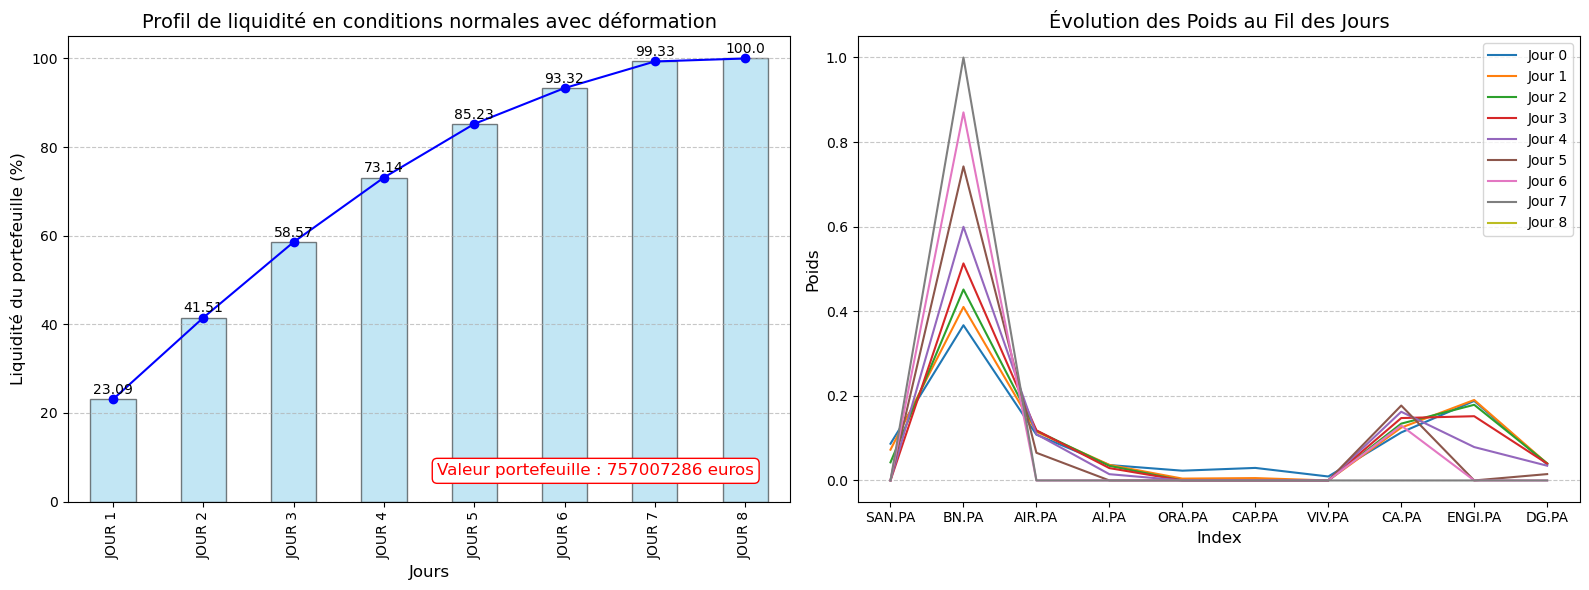

In [244]:
portfolio_liquidity = liqudity(df_volume)
liquidity_profile(portfolio_liquidity)

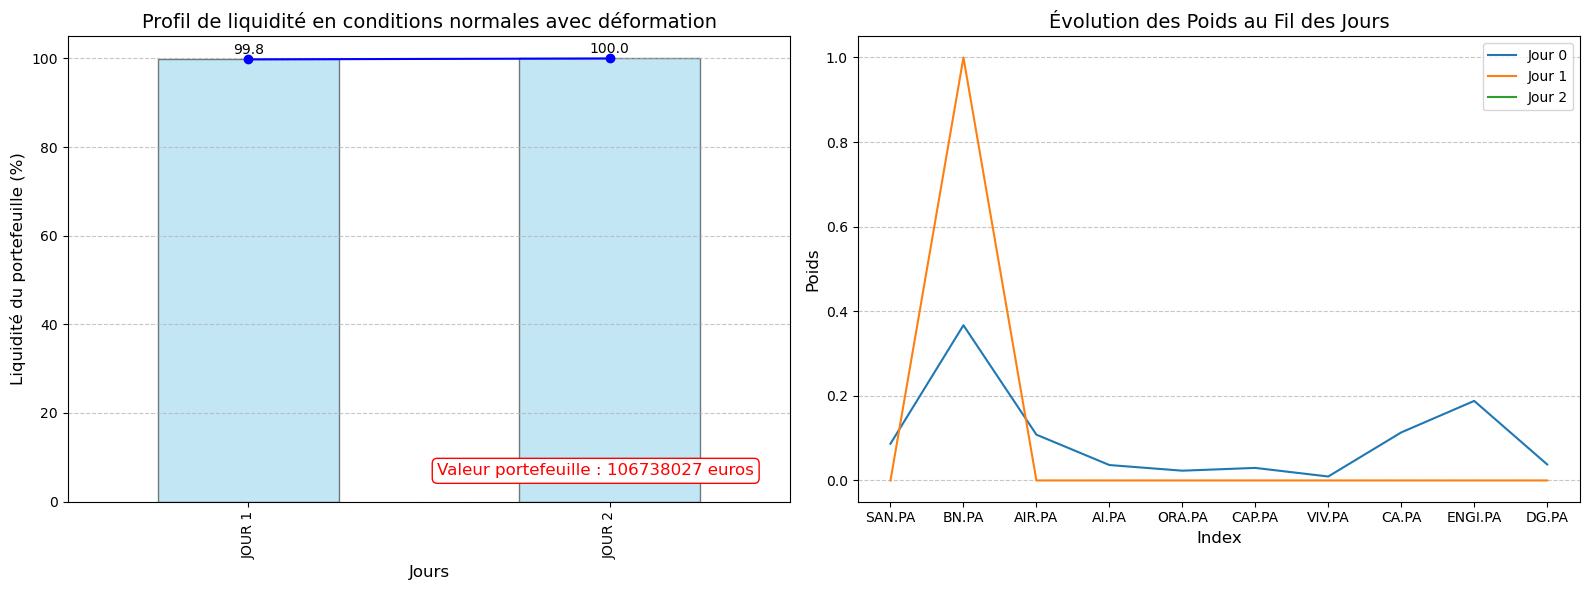

In [245]:
portfolio_liquidity = liqudity(df_volume, weight_adjust=0.141) # Taille optimale du portefeuille
liquidity_profile(portfolio_liquidity)

# Afficher la taille du portefeuille

## Profile de liquidité en conditions stressée avec déformation

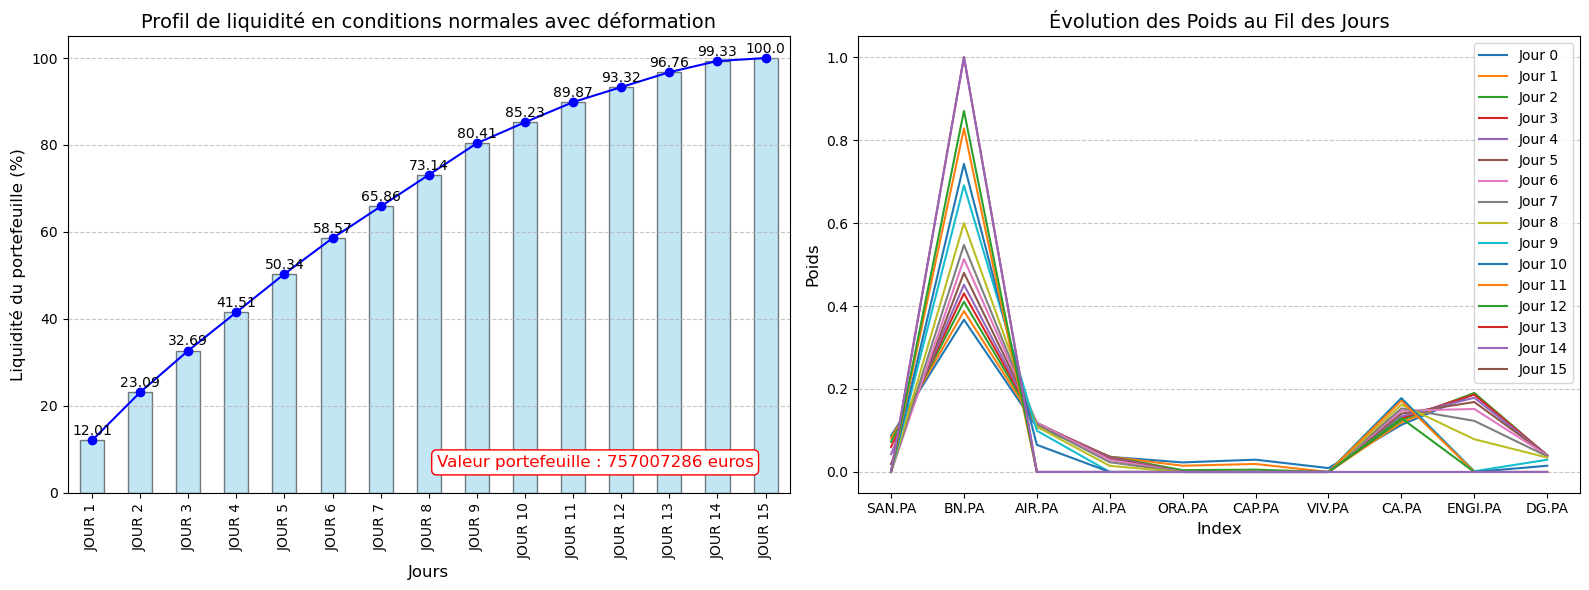

In [246]:
portfolio_liquidity = liqudity(df_volume, ADV_rate=0.1)
liquidity_profile(portfolio_liquidity)

## Profil d'écoulement sans déformation

In [247]:
def liqudity_proformat(df_volume, ADV_rate = 0.2, weight_adjust = 1):
    # Calcul de la moyenne mobile du volume (ADV) sur une fenêtre de 60 jours
    ADV = df_volume.rolling(window=60).mean()

    # Extraction de la dernière ligne (les valeurs ADV les plus récentes)
    latest_ADV = ADV.iloc[-1,]  # Cela donne l'ADV le plus récent pour tous les tickers

    # Création d'un DataFrame pour la liquidité du portefeuille
    portfolio_liquidity = pd.DataFrame({'Ticker': tickers, 'ADV': latest_ADV.values, 'Prix': df_close.iloc[-1,].values})

    # Définir 'Ticker' comme index pour un accès plus facile
    portfolio_liquidity = portfolio_liquidity.set_index('Ticker')

    # Calcul de la quantité (QUANTITE) basée sur le volume le plus récent
    np.random.seed(42)
    portfolio_liquidity["QUANTITE"] = weight_adjust*1.5*np.random.uniform(0,1,10)*portfolio_liquidity['ADV']

    # Calcul de la quantité liquidable (20 % de l'ADV)
    portfolio_liquidity['QUANTITE LIQUIDABLE'] = ADV_rate * portfolio_liquidity['ADV']

    # Calcul du nombre de jours de liquidation
    portfolio_liquidity['NB_JOURS DE LIQUIDATION'] = np.ceil(
        portfolio_liquidity['QUANTITE'] / portfolio_liquidity['QUANTITE LIQUIDABLE']
    )

    i = 1
    # Initialize the first day's liquidation (JOUR 1)

    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity['QUANTITE'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {0}'] = portfolio_liquidity[f'POIDS {0}']/portfolio_liquidity[f'POIDS {0}'].sum()
    
    portfolio_liquidity[f'JOUR {i}'] = portfolio_liquidity['QUANTITE'] - portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE'])
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
    portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()
    
    portfolio_liquidity[f'SPEED {i}'] = portfolio_liquidity['QUANTITE'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE']) /  portfolio_liquidity['QUANTITE']

    # Continue calculating for subsequent days while there is quantity remaining
    while portfolio_liquidity[f'JOUR {i}'].max() > 0:
        i += 1
        portfolio_liquidity[f'JOUR {i}'] = (
            (portfolio_liquidity[f'JOUR {i-1}'] - portfolio_liquidity[f'JOUR {i-1}']*portfolio_liquidity[f'SPEED {i-1}'].min())
    ).clip(lower=0)
        
        # Mise à jour des poids
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'JOUR {i}'] * portfolio_liquidity['Prix']
        portfolio_liquidity[f'POIDS {i}'] = portfolio_liquidity[f'POIDS {i}']/portfolio_liquidity[f'POIDS {i}'].sum()
        
        portfolio_liquidity[f'SPEED {i}'] = portfolio_liquidity[f'JOUR {i}'].clip(upper=portfolio_liquidity['QUANTITE LIQUIDABLE']) /  portfolio_liquidity[f'JOUR {i}']
        
    return portfolio_liquidity


## Profil de liquidité en conditions normales sans déformation

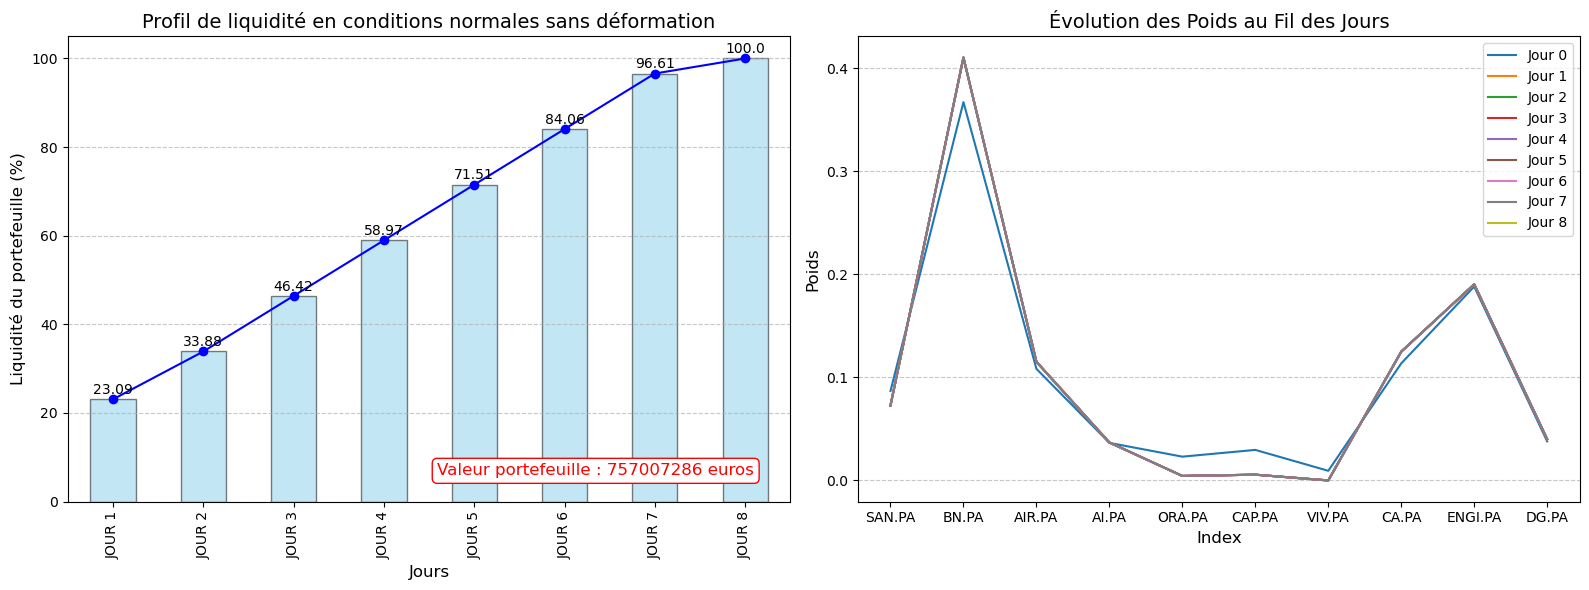

In [250]:
portfolio_liquidity = liqudity_proformat(df_volume)
liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions normales sans déformation")

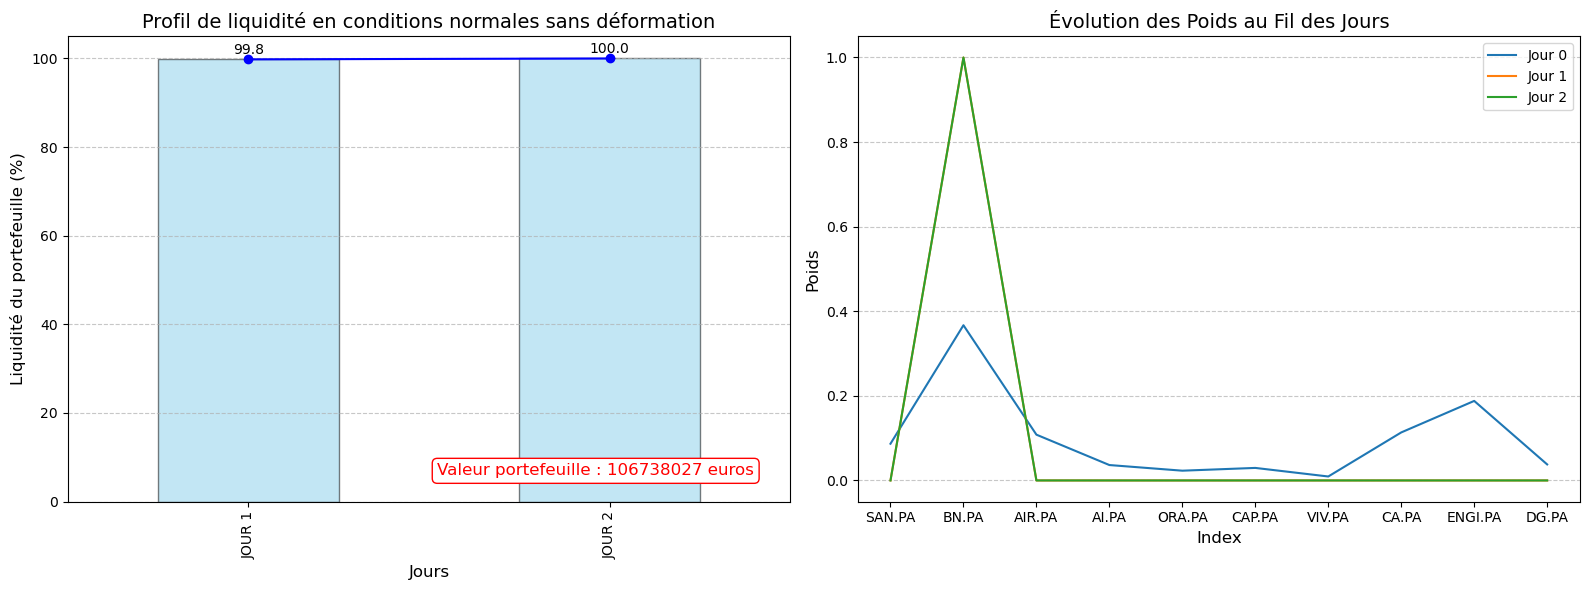

In [251]:
portfolio_liquidity = liqudity_proformat(df_volume, weight_adjust=0.141)
liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions normales sans déformation")

## Profil de liquidité en conditions stressée sans déformation

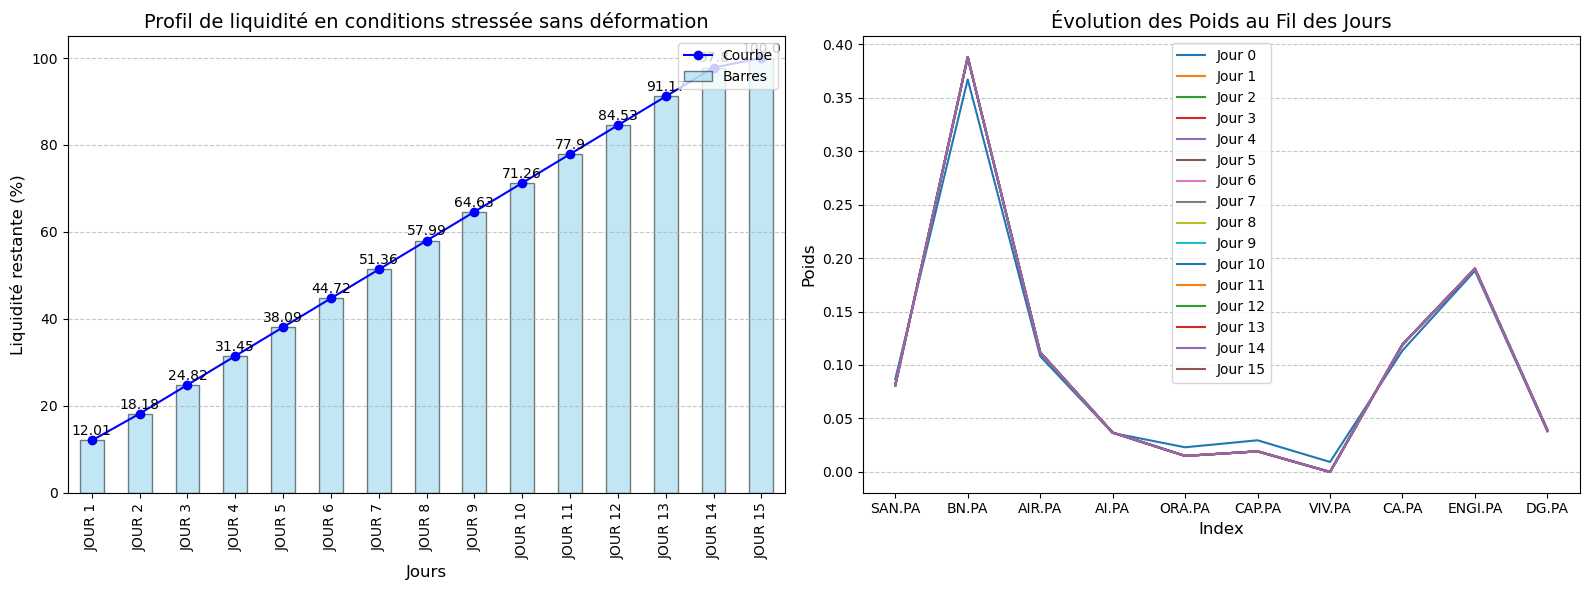

In [212]:
portfolio_liquidity = liqudity_proformat(df_volume, ADV_rate=0.1)
liquidity_profile(portfolio_liquidity, label="Profil de liquidité en conditions stressée sans déformation")